# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2023-spring@googlegroups.com

Slide:    [Link](https://docs.google.com/presentation/d/18LkR8qulwSbi3SVoLl1XNNGjQQ_qczs_35lrJWOmHCk/edit?usp=sharing)　Kaggle: [Link](https://www.kaggle.com/t/c76950cc460140eba30a576ca7668d28)

# Set up the environment


## Package installation

In [1]:
# # Training progress bar
# !pip install -q qqdm

## Downloading data

In [2]:
# !git lfs clone https://github.com/chiyuanhsiao/ml2023spring-hw8

# Import packages

In [1]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [2]:

train = np.load('ml2023spring-hw8/trainingset.npy', allow_pickle=True)
test = np.load('ml2023spring-hw8/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [3]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

In [10]:
from torchvision.models import resnet18, resnet50


class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(), 
            nn.Linear(12, 3)
        )    # Hint: dimension of latent space can be adjusted
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(), 
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x[:,0] = 2*x[:,0]
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self, hidden_dim=96):
        super(conv_autoencoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, self.hidden_dim, 4, stride=2, padding=1),         
            # nn.ReLU(),
            nn.LeakyReLU(0.03),     
            nn.BatchNorm2d(self.hidden_dim, momentum=0.01),   
            
            nn.Conv2d(self.hidden_dim, self.hidden_dim*2, 4, stride=2, padding=1),        
            # nn.ReLU(),
            nn.LeakyReLU(0.03),     
            nn.BatchNorm2d(self.hidden_dim*2, momentum=0.01),   
            
			nn.Conv2d(self.hidden_dim*2, self.hidden_dim*4, 4, stride=2, padding=1),         
            # nn.ReLU(),
            nn.LeakyReLU(0.03),     
            nn.BatchNorm2d(self.hidden_dim*4, momentum=0.01),   
            
        )   # Hint:  dimension of latent space can be adjusted
        self.decoder = nn.Sequential(
	        nn.ConvTranspose2d(self.hidden_dim*4, self.hidden_dim*2, 4, stride=2, padding=1),
            # nn.ReLU(),
            nn.LeakyReLU(0.03),     
            nn.BatchNorm2d(self.hidden_dim*2, momentum=0.01),   
            
			nn.ConvTranspose2d(self.hidden_dim*2, self.hidden_dim, 4, stride=2, padding=1), 
            # nn.ReLU(),
            nn.LeakyReLU(0.03),     
            nn.BatchNorm2d(self.hidden_dim, momentum=0.01),  
             
            nn.ConvTranspose2d(self.hidden_dim, 3, 4, stride=2, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(3, momentum=0.01),   
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self, resnet_as_encoder=False):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 3, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Hint: can add more layers to encoder and decoder
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )
        
        
        if resnet_as_encoder:
            self.encoder_output_dim = 96
            self.encoder = nn.Sequential( *list(resnet50().children())[:-1],
                                          nn.Conv2d(2048, self.encoder_output_dim, 1, stride=1, padding=0),
                                            nn.ReLU(),)
            
            self.enc_out_1 = nn.Sequential(
            nn.Conv2d(self.encoder_output_dim, self.encoder_output_dim*2, 3, stride=2, padding=1),  
            nn.ReLU(),
            )
            self.enc_out_2 = nn.Sequential(
                nn.Conv2d(self.encoder_output_dim, self.encoder_output_dim*2, 3, stride=2, padding=1),
                nn.ReLU(),
            )
            
            temp_encoder_output_dim = self.encoder_output_dim*2
            # decoder_layers = [nn.ConvTranspose2d(temp_encoder_output_dim, temp_encoder_output_dim, 4, stride=2, padding=1)]
            decoder_layers = []
            while temp_encoder_output_dim != 6:
                decoder_layers.append(nn.ConvTranspose2d(temp_encoder_output_dim, temp_encoder_output_dim//2, 4, stride=2, padding=1))
                decoder_layers.append(nn.ReLU())
                temp_encoder_output_dim = temp_encoder_output_dim//2

            
            self.decoder = nn.Sequential(
                *decoder_layers,
                nn.ConvTranspose2d(6, 3, 4, stride=2, padding=1), 
                nn.Tanh(),
            )
            
    def encode(self, x):
        h1 = self.encoder(x)
        
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
    

class ResnetVAE(nn.Module):
    def __init__(self, resnet_as_encoder=True, z_dim=20):
        super(ResnetVAE, self).__init__()
        self.z_dim = z_dim

        # Use ResNet-50 model, without the fully connected layer
        if resnet_as_encoder:
            self.base_encoder = resnet50()
            self.base_encoder = nn.Sequential(*list(self.base_encoder.children())[:-1])
            self.fc_mu = nn.Linear(2048, z_dim)
            self.fc_logvar = nn.Linear(2048, z_dim)
        else:
            self.base_encoder = nn.Sequential(
                nn.Conv2d(3, 12, 4, stride=2, padding=1),            
                nn.ReLU(),
                nn.Conv2d(12, 24, 4, stride=2, padding=1),    
                nn.ReLU(),
            )
            self.fc_mu = nn.Sequential(
                nn.Conv2d(24, 48, 4, stride=2, padding=1),  
                nn.ReLU(),
            )
            self.fc_logvar = nn.Sequential(
                nn.Conv2d(24, 48, 4, stride=2, padding=1),
                nn.ReLU(),
            )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 48, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 6, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )
        
    def encode(self, x):
        h1 = self.base_encoder(x)
        h1 = h1.view(h1.size(0), -1)  # Flatten each sample
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        z = z.view(z.size(0), self.z_dim, 1, 1)  # Reshape for the decoder
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [5]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [11]:
# Training hyperparameters
num_epochs = 50
batch_size = 256 # Hint: batch size may be lower
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'fcn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet_vae'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(hidden_dim=256), 'vae': VAE(), 'resnet_vae': VAE(resnet_as_encoder=True), 'resnet_vae_2': ResnetVAE(resnet_as_encoder=True, z_dim=512)} 
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training loop

In [12]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae', 'resnet_vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                               
 0/50           -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/50   00:00:04<00:03:39  0.22it/s  1/50   0.1795                              
Description   2.0% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 2/50   00:00:08<00:03:33  0.22it/s  2/50   0.1532                              
Description   4.0% |██                                                         | Iters    Elapsed Time      Speed    epoch   loss                               
 3/50   00:00:13<00:03:27  0.23it/s  3/50   0.1492                              
Description   6.0% |███                                                        | Iters    Elapsed Time      Spee

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [10]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'last_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

# prediction file 
out_file = 'prediction.csv'

In [26]:
anomality = list()
with torch.no_grad():
  qqdm_test = qqdm(test_dataloader, desc=format_str('bold', 'Description'))
  for i, data in enumerate(qqdm_test):
    img = data.float().cuda()
    print(img.shape)
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
      print(img.shape)
    output = model(img)
    if model_type in ['vae', 'resnet_vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1, 2, 3])
    anomality.append(loss)
    qqdm_test.set_infos({'loss': f'{loss.mean():.4f}'})
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')

 Iters    Elapsed Time      Speed                                               
 0/99           -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time       Speed      loss                                    
 15/99  00:00:00<00:00:01  72.79it/s  1912.7676                                 
Description  15.2% |████████                                                   |

torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])

 Iters    Elapsed Time       Speed      loss                                    
 38/99  00:00:00<00:00:00  91.58it/s  2127.6580                                 
Description  38.4% |██████████████████████                                     |

torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])

 Iters    Elapsed Time       Speed      loss                                    
 61/99  00:00:00<00:00:00  97.93it/s  2012.5608                                 
Description  61.6% |████████████████████████████████████                       |

torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])

 Iters    Elapsed Time       Speed       loss                                   
 84/99  00:00:00<00:00:00  101.88it/s  1957.1565                                
Description  84.8% |██████████████████████████████████████████████████         |

torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])

 Iters    Elapsed Time       Speed       loss                                   
 99/99  00:00:00<00:00:00  100.94it/s  2098.6792                                
Description 100.0% |███████████████████████████████████████████████████████████|

torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([200, 3, 64, 64])
torch.Size([200, 12288])
torch.Size([36, 3, 64, 64])
torch.Size([36, 12288])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([12288])
(64, 64, 3) (64, 64, 3)


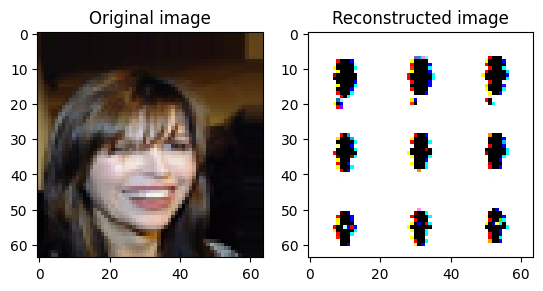

In [14]:
# Show an original image and a reconstruction image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
with torch.no_grad():
    model.eval()
    # for data in test_dataloader:
    original_img = train[0]
    output = model(torch.tensor(original_img).float().cuda().view(1, 12288))
    # output = model(data.float().cuda().view(1,test[0].shape[0], -1))
    print(output[0].shape)

    recon_img = output[0].cpu().view(64, 64, 3).numpy()
    print(recon_img.shape, original_img.shape)
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(recon_img)
    plt.title('Reconstructed image')
    plt.show()
        # break
